In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

# GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
file = "dataset_file/file.txt"

splitted_line = []

with open(file) as f:
    for line in f.readlines():
        # print(line)
        if  int(line[0]) in [1,2,3,4]:
            splitted_line.append([line[0], line[2:]])


print(splitted_line.pop(0))



['1', 'champion products ch approves stock split champion products inc said its board of directors approved a two for one stock split of its common shares for shareholders of record as of april the company also said its board voted to recommend to shareholders at the annual meeting april an increase in the authorized capital stock from five mln to mln shares reuter \n']


In [29]:
dataset = pd.DataFrame(list(splitted_line), columns=["labels", "text"])

In [30]:
dataset.head()

,labels,text
0,2,computer terminal systems cpml completes sale ...
1,1,cobanco inc cbco year net shr cts vs dlrs net ...
2,1,am international inc am nd qtr jan oper shr lo...
3,1,brown forman inc bfd th qtr net shr one dlr vs...
4,1,dean foods df sees strong th qtr earnings dean...


In [31]:
X = dataset["text"].values
y = dataset["labels"].values

y = to_categorical(y)

In [32]:
tokenizer = Tokenizer(num_words= None)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# # Example
# print(X[0])
# print(sequences[0])

computer terminal systems cpml completes sale computer terminal systems inc said it has completed the sale of shares of its common stock and warrants to acquire an additional one mln shares to sedio n v of lugano switzerland for dlrs the company said the warrants are exercisable for five years at a purchase price of dlrs per share computer terminal said sedio also has the right to buy additional shares and increase its total holdings up to pct of the computer terminal s outstanding common stock under certain circumstances involving change of control at the company the company said if the conditions occur the warrants would be exercisable at a price equal to pct of its common stock s market price at the time not to exceed dlrs per share computer terminal also said it sold the technolgy rights to its dot matrix impact technology including any future improvements to woodco inc of houston tex for dlrs but it said it would continue to be the exclusive worldwide licensee of the technology fo

In [33]:
X_encoded = pad_sequences(sequences, maxlen=80, padding='post')

print(X_encoded[0])

[  356  2036    62     9    12   247     1 10762   385     3    18  1214
  6587   739   433   305   190   357  2302     3  8061    23     2  1278
  8062    13    10    63    12     9    12    47   348     3    33     1
  2973  1012  3406     2     1   433    13  8061     1    21     9     1
  1215    76   253     2    18  1360   224     8    47   667    96   159
   646   271     8  2037   632  1427   356  2036   625   356  2974  5636
  2639 10763     8  3986  4936     8  3664    15]


In [42]:
# Split into training set and test set. Use a test size = 3000 and a random state = 0
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.10, random_state=0,stratify = y)

In [45]:
X_train_one, X_train_two, y_train_one, y_test_two = train_test_split(X_train, y_train, test_size=0.50, random_state=44,stratify = y_train)

In [47]:
# Design a LSTM neural network and use an embedding layer.
vocabulary_size = X_train_one.max()

model = Sequential()
model.add(Embedding(vocabulary_size+1, 150, input_length=80))
model.add(SpatialDropout1D(0.3))
# model.add(LSTM(500,return_sequences=True, dropout=0.2, recurrent_dropout=0.15))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(500, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [22]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from datetime import datetime, date
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=5, restore_best_weights=True)

END = f'{datetime.timestamp(datetime.now())}_{date.today().strftime("%b-%d-%Y")}'

NAME = 'logs/text_classification_model{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir=f'{NAME}_{END}')

checkpoint_filepath = f'models/text_classification_{END}.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

callback_list = [tensorboard, checkpointer, es]

In [50]:
history = model.fit(X_train_one, y_train_one, epochs=100,verbose=1,batch_size=128, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
14/14 [==============================] - 17s 1s/step - loss: 1.0595 - accuracy: 0.5994 - val_loss: 0.8919 - val_accuracy: 0.6713
Epoch 2/100
14/14 [==============================] - 18s 1s/step - loss: 0.8278 - accuracy: 0.6174 - val_loss: 0.8184 - val_accuracy: 0.6736
Epoch 3/100
14/14 [==============================] - 17s 1s/step - loss: 0.7458 - accuracy: 0.7003 - val_loss: 0.7568 - val_accuracy: 0.6644
Epoch 4/100
14/14 [==============================] - 17s 1s/step - loss: 0.6283 - accuracy: 0.7774 - val_loss: 0.6674 - val_accuracy: 0.7407
Epoch 5/100
14/14 [==============================] - 17s 1s/step - loss: 0.3793 - accuracy: 0.8754 - val_loss: 0.3328 - val_accuracy: 0.8958
Epoch 6/100
14/14 [==============================] - 16s 1s/step - loss: 0.2242 - accuracy: 0.9328 - val_loss: 0.4232 - val_accuracy: 0.8750
Epoch 7/100
14/14 [==============================] - 16s 1s/step - loss: 0.1482 - accuracy: 0.9536 - val_loss: 0.4006 - val_accuracy: 0.9097
Epoch 8/100
1

In [54]:
history = model.fit(X_train_two, y_test_two, epochs=100,verbose=1,batch_size=128, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
14/14 [==============================] - 17s 1s/step - loss: 0.3071 - accuracy: 0.9107 - val_loss: 0.3540 - val_accuracy: 0.9051
Epoch 2/100
14/14 [==============================] - 17s 1s/step - loss: 0.1644 - accuracy: 0.9478 - val_loss: 0.2471 - val_accuracy: 0.9120
Epoch 3/100
14/14 [==============================] - 17s 1s/step - loss: 0.1028 - accuracy: 0.9693 - val_loss: 0.4014 - val_accuracy: 0.9028
Epoch 4/100
14/14 [==============================] - 18s 1s/step - loss: 0.0962 - accuracy: 0.9693 - val_loss: 0.3445 - val_accuracy: 0.9005
Epoch 5/100
14/14 [==============================] - 17s 1s/step - loss: 0.0790 - accuracy: 0.9757 - val_loss: 0.3086 - val_accuracy: 0.9074
Epoch 6/100
14/14 [==============================] - 16s 1s/step - loss: 0.0559 - accuracy: 0.9826 - val_loss: 0.2797 - val_accuracy: 0.9167
Epoch 7/100
14/14 [==============================] - 15s 1s/step - loss: 0.0452 - accuracy: 0.9809 - val_loss: 0.2703 - val_accuracy: 0.9074
Restoring mod

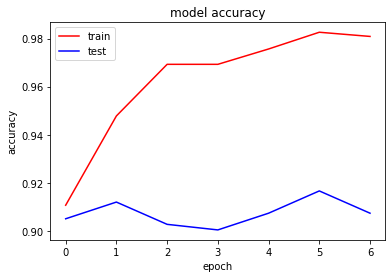

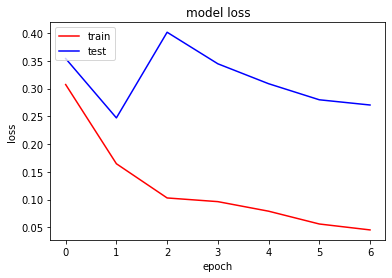

In [55]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
# Validate model on training set
rounded_labels=np.argmax(y_test, axis=1)

y_pred = np.argmax(model.predict(X_test),axis=-1)

print(classification_report(rounded_labels, y_pred))

cf = confusion_matrix(rounded_labels, y_pred)

print(cf)
print(accuracy_score(rounded_labels, y_pred) * 100) 

              precision    recall  f1-score   support

           1       0.99      0.94      0.97       284
           2       0.88      0.98      0.93       160
           3       0.71      0.80      0.75        25
           4       0.50      0.09      0.15        11

    accuracy                           0.93       480
   macro avg       0.77      0.70      0.70       480
weighted avg       0.93      0.93      0.92       480

[[268  16   0   0]
 [  3 157   0   0]
 [  0   4  20   1]
 [  0   2   8   1]]
92.91666666666667


In [5]:
labels = ["business", "entertainment", "politics", "sport", "tech"]
targets = [0,1,2,3,4]
dataset = []
for root, dirs, files in os.walk("./archive/bbc", topdown=False):
    class_type = root.split("\\")
    print(class_type)
    if len(class_type)> 1:
        for file in files: 
            with open(root+"/"+file) as f: 
                text = f.read()
                dataset.append([class_type[1], text])  

['./archive/bbc', 'business']
['./archive/bbc', 'entertainment']
['./archive/bbc', 'politics']
['./archive/bbc', 'sport']
['./archive/bbc', 'tech']
['./archive/bbc']


In [6]:
print(len(dataset))

2225


In [8]:
import pickle

with open('./archive/bbc/dataset.list', "wb") as f: 
    pickle.dump(dataset, f)

In [10]:
with open('./archive/bbc/dataset.list', "rb") as f: 
    dataset = pickle.load(f)

print(len(dataset))

2225


In [12]:
dataset = pd.DataFrame(list(dataset), columns=["labels", "text"])

In [14]:
dataset["labels"] = dataset["labels"].replace({"business":0, "entertainment":1, "politics":2, "sport":3, "tech":4})

In [15]:
X = dataset["text"].values
y = dataset["labels"].values

y = to_categorical(y)

In [16]:
tokenizer = Tokenizer(num_words= None)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# # Example
# print(X[0])
# print(sequences[0])

In [19]:
X_encoded = pad_sequences(sequences, maxlen=120, padding='post')

print(X_encoded[0])

[ 1471     4  2210  1049  4685  8262     8     2  6615    40  1165    17
   151     3  1412     2  4090    32  1413    70  3300    21    48   117
  3301    12    18   191   959     2   349  6241     2  2609   881     6
     5   216     9     8   159  1391    21     1  2528     1   137    11
    12    13  2390     2  3129     1   911    12   510     2   109  2852
     7   357  2853    34    12  1015   109    20  4887    12  4366     2
  9962     1   114    12  1165     7     5   216    16   786    99  4888
 20599  2669     3     5  1266     6  3300   264    34    12    35   613
    17  2177  1471    12    22    67   640     1   444     3    40  1266
     6  3300   264    17     5  1197    10     1   792     3     9  1266]


In [18]:
# Split into training set and test set. Use a test size = 3000 and a random state = 0
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.10, random_state=0,stratify = y)

In [35]:
# Design a LSTM neural network and use an embedding layer.
vocabulary_size = X_train.max()

model = Sequential()
model.add(Embedding(vocabulary_size+1, 150, input_length=120))
model.add(SpatialDropout1D(0.3))
# model.add(LSTM(500,return_sequences=True, dropout=0.2, recurrent_dropout=0.15))
model.add(LSTM(100, dropout=0.15, recurrent_dropout=0.1))
model.add(Dense(750, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [36]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from datetime import datetime, date
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=5, restore_best_weights=True)

END = f'{datetime.timestamp(datetime.now())}_{date.today().strftime("%b-%d-%Y")}'

NAME = 'logs/bbc/bbc_classification_log_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir=f'{NAME}_{END}')

checkpoint_filepath = f'models/bbc/bbc_classification_{END}.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

callback_list = [tensorboard, checkpointer, es]

In [37]:
history = model.fit(X_train, y_train, epochs=100,verbose=1,batch_size=128, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
13/13 [==============================] - 24s 2s/step - loss: 1.6061 - accuracy: 0.2386 - val_loss: 1.5928 - val_accuracy: 0.3616
Epoch 2/100
13/13 [==============================] - 18s 1s/step - loss: 1.4890 - accuracy: 0.4072 - val_loss: 1.2754 - val_accuracy: 0.4464
Epoch 3/100
13/13 [==============================] - 18s 1s/step - loss: 1.0889 - accuracy: 0.4753 - val_loss: 0.9855 - val_accuracy: 0.5287
Epoch 4/100
13/13 [==============================] - 19s 1s/step - loss: 0.6488 - accuracy: 0.7402 - val_loss: 0.7394 - val_accuracy: 0.7606
Epoch 5/100
13/13 [==============================] - 21s 2s/step - loss: 0.3135 - accuracy: 0.9082 - val_loss: 0.6416 - val_accuracy: 0.7456
Epoch 6/100
13/13 [==============================] - 17s 1s/step - loss: 0.1293 - accuracy: 0.9588 - val_loss: 0.6840 - val_accuracy: 0.7905
Epoch 7/100
13/13 [==============================] - 21s 2s/step - loss: 0.0537 - accuracy: 0.9819 - val_loss: 0.7110 - val_accuracy: 0.7905
Epoch 8/100
1

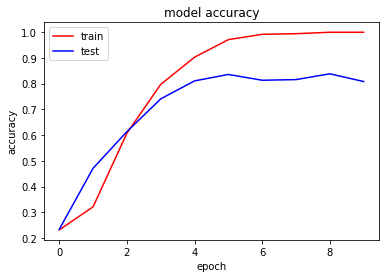

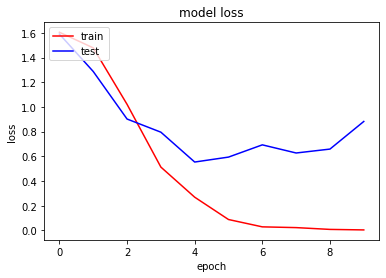

In [34]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()